# Librerias

In [1]:
random_state = 43992294
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as ss
import os
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MultiLabelBinarizer

from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer

import ast

import warnings

from tqdm.auto import tqdm

from sklearn.feature_selection import RFECV

from sklearn.model_selection import StratifiedKFold, cross_val_score

from itertools import chain

import dask.dataframe as dd

# Cython imports
from tools import agrupar_categorias_cython, custom_one_hot_encoder_cython, boolean_features_ohe_cython, verificar_festividades_cython, agrupar_edades_cython

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Fuciones

In [4]:
# Desactivar warnings
warnings.filterwarnings('ignore')

def augment_train_data(main_train_df, supplementary_df, umbral_raras=100):
    """
    Agrega filas del dataset suplementario al conjunto de entrenamiento principal
    basándose en categorías desconocidas y raras, evitando la duplicación de filas.

    Parámetros:
    - main_train_df (pd.DataFrame): DataFrame principal de entrenamiento.
    - supplementary_df (pd.DataFrame): DataFrame suplementario del cual se extraerán las filas.
    - umbral_raras (int): Umbral de frecuencia para considerar una categoría como rara.

    Retorna:
    - main_train_df (pd.DataFrame): DataFrame de entrenamiento actualizado.
    - categorias_desconocidas (dict): Diccionario actualizado de categorías desconocidas.
    - categorias_raras (dict): Diccionario actualizado de categorías raras.
    """
    # Definir columnas que no deseas tratar como categóricas
    columns_to_exclude = ['auction_list_0', 'action_list_1', 'action_list_2', 'auction_time']

    # Identificar columnas categóricas excluyendo las especificadas
    categorical_features = main_train_df.select_dtypes(include=['object']).columns.tolist()
    categorical_features = [col for col in categorical_features if col not in columns_to_exclude]
    
    # Crear un diccionario para almacenar las categorías desconocidas por columna
    categorias_desconocidas = {}
    
    # Iterar a través de cada columna categórica para identificar categorías desconocidas
    for columna in categorical_features:
        # Obtener las categorías únicas en el conjunto de entrenamiento
        categorias_train = set(main_train_df[columna].dropna().unique())
        
        # Obtener las categorías únicas en el dataset suplementario
        categorias_suplementario = set(supplementary_df[columna].dropna().unique())
        
        # Identificar las categorías en el dataset suplementario que no están en el entrenamiento
        desconocidas = categorias_suplementario - categorias_train
        
        # Almacenar las categorías desconocidas en el diccionario como una lista
        categorias_desconocidas[columna] = list(desconocidas)
    
    # Inicializar el diccionario para almacenar las categorías raras por columna
    categorias_raras = {}
    
    # Identificar categorías raras en el conjunto de entrenamiento
    for columna in categorical_features:
        # Contar la frecuencia de cada categoría
        frecuencia = main_train_df[columna].value_counts()
        
        # Identificar categorías que aparecen menos de umbral_raras veces
        raras = frecuencia[frecuencia < umbral_raras].index.tolist()
        
        # Almacenar en el diccionario
        categorias_raras[columna] = raras
    
    # Crear una máscara booleana para filas con categorías desconocidas o raras
    mask_desconocidas = pd.Series([False] * len(supplementary_df))
    mask_raras = pd.Series([False] * len(supplementary_df))
    
    for columna in categorical_features:
        # Actualizar la máscara para categorías desconocidas
        if categorias_desconocidas[columna]:
            mask_desconocidas = mask_desconocidas | supplementary_df[columna].isin(categorias_desconocidas[columna])
        
        # Actualizar la máscara para categorías raras
        if categorias_raras[columna]:
            mask_raras = mask_raras | supplementary_df[columna].isin(categorias_raras[columna])
    
    # Combinar ambas máscaras
    mask_total = mask_desconocidas | mask_raras
    
    # Filtrar filas únicas a agregar
    filas_a_agregar = supplementary_df[mask_total].drop_duplicates()
    
    # Mostrar información de agregación
    total_agregadas = len(filas_a_agregar)
    print(f"\nAgregando {total_agregadas} filas del dataset suplementario basadas en categorías desconocidas o raras.")
    
    # Agregar las filas al conjunto de entrenamiento
    main_train_df = pd.concat([main_train_df, filas_a_agregar], ignore_index=True)
    
    # Actualizar los diccionarios eliminando las categorías que ya han sido agregadas
    for columna in categorical_features:
        # Actualizar categorías desconocidas
        if categorias_desconocidas[columna]:
            categorias_agregadas = filas_a_agregar[columna].unique().tolist()
            categorias_desconocidas[columna] = [cat for cat in categorias_desconocidas[columna] if cat not in categorias_agregadas]
        
        # Actualizar categorías raras
        if categorias_raras[columna]:
            # Recontar la frecuencia después de agregar
            frecuencia = main_train_df[columna].value_counts()
            nuevas_raras = frecuencia[frecuencia < umbral_raras].index.tolist()
            categorias_raras[columna] = nuevas_raras
    
    return main_train_df, categorias_desconocidas, categorias_raras

def expand_list_dummies_cython(df, column, delimiter='|', prefix=None, suffix=None):
    """
    Expande una columna que contiene listas en múltiples columnas binarias usando un one-hot encoder optimizado con Cython.
    
    Parameters:
    - df (pd.DataFrame): DataFrame de pandas.
    - column (str): Nombre de la columna a expandir.
    - delimiter (str): Delimitador a usar en get_dummies (por defecto '|').
    - prefix (str, optional): Prefijo para las nuevas columnas binarias.
    - suffix (str, optional): Sufijo para las nuevas columnas binarias.
    
    Returns:
    - df_expanded (pd.DataFrame): DataFrame con las nuevas columnas binarias añadidas y la columna original eliminada.
    """
    # Copiar el DataFrame para evitar modificar el original
    df = df.copy()
    
    # Nombre para el valor desconocido
    unknown_value = f'Desconocido_{column[len(column)-1]}'
    
    # Reemplazar NaN por el valor desconocido
    df[column] = df[column].fillna(unknown_value)
    
    # Convertir las cadenas que representan listas en listas reales de Python
    def parse_list(x):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and len(parsed) == 0:
                # Tratar listas vacías como 'Desconocido'
                return [unknown_value]
            elif isinstance(parsed, list):
                # Convertir números a strings
                return [str(item) for item in parsed]
            else:
                return [str(x)]
        except (ValueError, SyntaxError):
            return [unknown_value]
    
    df[column] = df[column].apply(parse_list)
    
    # Convertir la columna en una lista de listas para pasarla a la función Cythonizada
    data_list = df[column].tolist()
    
    # Llamar a la función optimizada en Cython
    unique_categories, binary_matrix = custom_one_hot_encoder_cython(data_list)
    
    # Crear un DataFrame binario usando la matriz devuelta por Cython
    binary_df = pd.DataFrame(binary_matrix, index=df.index, columns=unique_categories)
    
    # Añadir prefijo y/o sufijo si se especifica
    if prefix:
        binary_df = binary_df.add_prefix(f"{prefix}_")
    if suffix:
        binary_df = binary_df.add_suffix(f"_{suffix}")
    
    # Concatenar las columnas binarias al DataFrame original, asegurando que solo se asigna 1, no se suma
    for col in binary_df.columns:
        if col in df.columns:
            df[col] = np.where((df[col] == 1) | (binary_df[col] == 1), 1, 0)
        else:
            df[col] = binary_df[col]
    
    # Eliminar la columna original ya que ha sido expandida
    df = df.drop(columns=[column])
    
    return df

def boolean_features_ohe(df, columns_to_encode=['auction_boolean_0', 'auction_boolean_1', 'auction_boolean_2']):
    """
    Unifica el proceso de one-hot encoding utilizando Cython para acelerar el proceso en las columnas booleanas.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame original con las columnas booleanas.
    - columns_to_encode (list): Lista de columnas a codificar.
    
    Retorna:
    - df_expanded (pd.DataFrame): DataFrame con las nuevas columnas codificadas añadidas y las columnas booleanas originales eliminadas.
    """
    # Encontrar todos los valores únicos en esas columnas
    unique_values = pd.concat([df[col] for col in columns_to_encode]).dropna().unique().tolist()
    
    # Convertir las columnas a listas de listas para ser procesadas en Cython
    list_data = [df[col].tolist() for col in columns_to_encode]
    
    # Procesar con Cython
    ohe_result = boolean_features_ohe_cython(list_data, unique_values)
    
    # Convertir el resultado a un DataFrame
    ohe_df = pd.DataFrame(ohe_result, columns=unique_values)
    
    # Concatenar las nuevas columnas al DataFrame original
    df_expanded = pd.concat([df, ohe_df], axis=1)
    
    # Eliminar las columnas originales
    df_expanded.drop(columns=columns_to_encode, inplace=True)
    
    return df_expanded

def time_features_extension(df):
    """
    Procesa las características temporales del DataFrame y agrega nuevas columnas derivadas relacionadas con el tiempo y festividades.
    """

    # Convertir 'auction_time' de timestamp a una fecha legible
    df['auction_time'] = pd.to_datetime(df['auction_time'], unit='s')

    # Reemplazar NaN en 'timezone_offset' por 0
    df['timezone_offset'] = df['timezone_offset'].fillna(0)

    # Ajustar la hora según el 'timezone_offset' para obtener la hora local
    df['auction_time_local'] = df.apply(
        lambda row: row['auction_time'] + pd.DateOffset(hours=row['timezone_offset']), axis=1
    )

    # Crear la columna 'week_day' (1 para lunes, 7 para domingo)
    df['week_day'] = df['auction_time_local'].dt.weekday + 1

    # Corregir la columna 'time_of_month' para incluir todos los días del mes
    df['time_of_month'] = pd.cut(df['auction_time_local'].dt.day, 
                                 bins=[0, 10, 20, 31], labels=[1, 2, 3], include_lowest=True, right=True)

    # Crear la columna 'moment_of_the_day' (1 para temprano, 2 para tarde, 3 para noche)
    df['moment_of_the_day'] = pd.cut(df['auction_time_local'].dt.hour, 
                                     bins=[0, 12, 18, 24], labels=[1, 2, 3], include_lowest=True, right=False)

    # Usar la función de Cython para verificar festividades
    # Convertir la columna 'auction_time_local' en una lista de tuplas (año, mes, día)
    auction_times = [(time.year, time.month, time.day) for time in df['auction_time_local']]

    # Aplicar la función de Cython para obtener la columna 'close_to_festivity'
    df['close_to_festivity'] = verificar_festividades_cython(auction_times)

    # Eliminar las columnas originales 'auction_time', 'timezone_offset' y 'auction_time_local'
    df.drop(columns=['auction_time', 'timezone_offset', 'auction_time_local'], inplace=True)

    return df

def age_group(df, columna_edad):
    """
    Agrupa las edades en rangos numéricos utilizando Cython para mejorar el rendimiento.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene la columna de edades.
    - columna_edad (str): Nombre de la columna que contiene las edades.

    Retorna:
    - df (pd.DataFrame): DataFrame con la nueva columna 'age_group' que representa el rango de edad.
    """
    # Convertir la columna de edad a una lista
    edades = df[columna_edad].tolist()

    # Usar la función Cythonizada para agrupar las edades
    df['age_group'] = agrupar_edades_cython(edades)

    # Eliminar la columna original de edades
    df.drop(columns=[columna_edad], inplace=True)

    return df

def process_optimized(df):
    """
    Aplica una serie de transformaciones al DataFrame utilizando una función Cython optimizada.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame a procesar.
    
    Retorna:
    - df (pd.DataFrame): DataFrame procesado.
    - categories (set): Conjunto de categorías creadas durante el procesamiento.
    """
    # Definir el número total de pasos para la barra de progreso
    total_steps = 6
    
    # Inicializar la barra de progreso
    with tqdm(total=total_steps, desc="Procesando DataFrame", unit="paso") as pbar:
        
        # 1. Agrupar categorías raras en 'Otro' y reemplazar NaN por 'Desconocidos' usando Cython
        # Preparar los datos
        columns_to_exclude = ['auction_list_0', 'action_list_1', 'action_list_2', 'auction_time', 'timezone_offset' 'auction_boolean_0', 'auction_boolean_1', 'auction_boolean_2', 'auction_age']
        categorical_features = df.select_dtypes(include=['object']).columns.tolist()
        categorical_features = [col for col in categorical_features if col not in columns_to_exclude]
        
        # Convertir a matriz bidimensional
        data_matrix = df[categorical_features].values.tolist()
        data_matrix_cython = [list(row) for row in data_matrix]
        
        # Llamar a la función Cythonizada
        df_cython_data = agrupar_categorias_cython(
            categorical_features=categorical_features,
            columns_to_exclude=columns_to_exclude,
            data=data_matrix_cython,
            umbral=0                             # Con un umbral de 0, modifico los valores NaN
        )
        
        # Reasignar los datos al DataFrame
        for i, col in enumerate(categorical_features):
            df[col] = [row[i] for row in df_cython_data]
        
        pbar.update(1)  # Actualizar la barra de progreso

        df = boolean_features_ohe(df)
        
        pbar.update(1)

        df = expand_list_dummies_cython(df, 'auction_list_0')
        pbar.update(1)
        
        df = expand_list_dummies_cython(df, 'action_list_1')
        pbar.update(1)
        
        df = expand_list_dummies_cython(df, 'action_list_2')
        pbar.update(1)
        
        df = time_features_extension(df)
        pbar.update(1)

        df = age_group(df, 'auction_age')
        pbar.update(1)
    
    return df

def process_data_with_dask(df, npartitions=10):
    """
    Procesa un DataFrame utilizando Dask para distribuir el trabajo en varias particiones.
    Aplica la función process_optimized a cada partición del DataFrame.
    
    Parámetros:
    - df (pd.DataFrame): El DataFrame de pandas a procesar.
    - npartitions (int): Número de particiones en las que se dividirá el DataFrame para su procesamiento.
    
    Retorna:
    - final_df (pd.DataFrame): El DataFrame procesado y concatenado.
    """
    # Convertir el DataFrame de pandas a Dask con el número de particiones especificado
    dask_df = dd.from_pandas(df, npartitions=npartitions)
    
    # Aplicar la función process_optimized a cada partición
    dask_df = dask_df.map_partitions(lambda df_partition: process_optimized(df_partition))
    
    # Ejecutar el cálculo distribuido y convertir el resultado a pandas
    final_df = dask_df.compute()

    return final_df

def cramers_v(confusion_matrix):
    """
    Calcula la estadística de Cramér's V para medir la asociación entre dos variables categóricas.

    Parameters:
    - confusion_matrix: Matriz de confusión (tabla de contingencia) entre dos variables.

    Returns:
    - Cramér's V: Valor entre 0 y 1 que indica la fuerza de la asociación.
    """
    # Calcular el estadístico chi-cuadrado
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    # Número total de observaciones
    n = confusion_matrix.sum().sum()
    # Obtener el número de filas y columnas de la matriz de confusión
    r, k = confusion_matrix.shape
    if min(r, k) == 1:
        return np.nan  # Evitar dividir por cero
    # Calcular Cramér's V
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Limpieza de datos

## Cancatenamos datasets

In [ ]:
train_data_21 = pd.read_csv('data/ctr_21.csv')

In [13]:
train_data_20 = pd.read_csv('data/ctr_20.csv')
train_data_19 = pd.read_csv('data/ctr_19.csv')
train_data_18 = pd.read_csv('data/ctr_18.csv')
train_data_17 = pd.read_csv('data/ctr_17.csv')
train_data_16 = pd.read_csv('data/ctr_16.csv')
train_data_15 = pd.read_csv('data/ctr_15.csv')

In [ ]:
supplementary_datasets = [
    ('1', train_data_20),
    ('2', train_data_19),
    ('3', train_data_18),
    ('4', train_data_17),
    ('5', train_data_16),
    ('6', train_data_15)
]

train_data = train_data_21

In [ ]:
for nombre, dataset in supplementary_datasets:
    print(f"\nProcesando dataset {nombre}/{len(supplementary_datasets)}")
    train_data, categorias_desconocidas, categorias_raras = augment_train_data(train_data, dataset)

In [ ]:
print(train_data.shape[0])

print(train_data_20.shape[0] + train_data_19.shape[0] + train_data_18.shape[0] + train_data_17.shape[0] + train_data_16.shape[0] + train_data_15.shape[0] + train_data_21.shape[0])

In [ ]:
train_data.to_csv('train_data_combined.csv', index=False)

## Ingenieria de atributos

In [13]:
train_data = pd.read_csv('train_data_combined.csv')

In [15]:
test = pd.read_csv('data/ctr_test.csv')

In [18]:
# Categorias numericas
numeric_columns = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorias categóricas
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

#### Distribucion de 'Label' 

In [4]:
# Imprimir la cantidad de filas del dataset combinado
print(f"Cantidad de filas en el dataset combinado: {train_data.shape[0]}")
print(f"Cantidad de columnas en el dataset combinado: {train_data.shape[1]}")

# Ver porcentaje de clics vs no clics en la columna Label
label_counts = train_data['Label'].value_counts(normalize=True) * 100
print("\nPorcentaje de clics (1) y no clics (0):")
print(label_counts)

# Cantidad de clics (1) y no clics (0)
label_counts_abs = train_data['Label'].value_counts()
print("\nCantidad de clics (1) y no clics (0):")
print(label_counts_abs)

Cantidad de filas en el dataset combinado: 8456028
Cantidad de columnas en el dataset combinado: 52

Porcentaje de clics (1) y no clics (0):
Label
0    98.767625
1     1.232375
Name: proportion, dtype: float64

Cantidad de clics (1) y no clics (0):
Label
0    8351818
1     104210
Name: count, dtype: int64


#### Correlaciones con 'Label'

##### Numeric features

Correlation of features with 'Label' (sorted by absolute value):
creative_height: 0.0973
auction_bidfloor: 0.0901
creative_width: 0.0389
timezone_offset: 0.0237
auction_time: 0.0176
auction_age: -0.0082


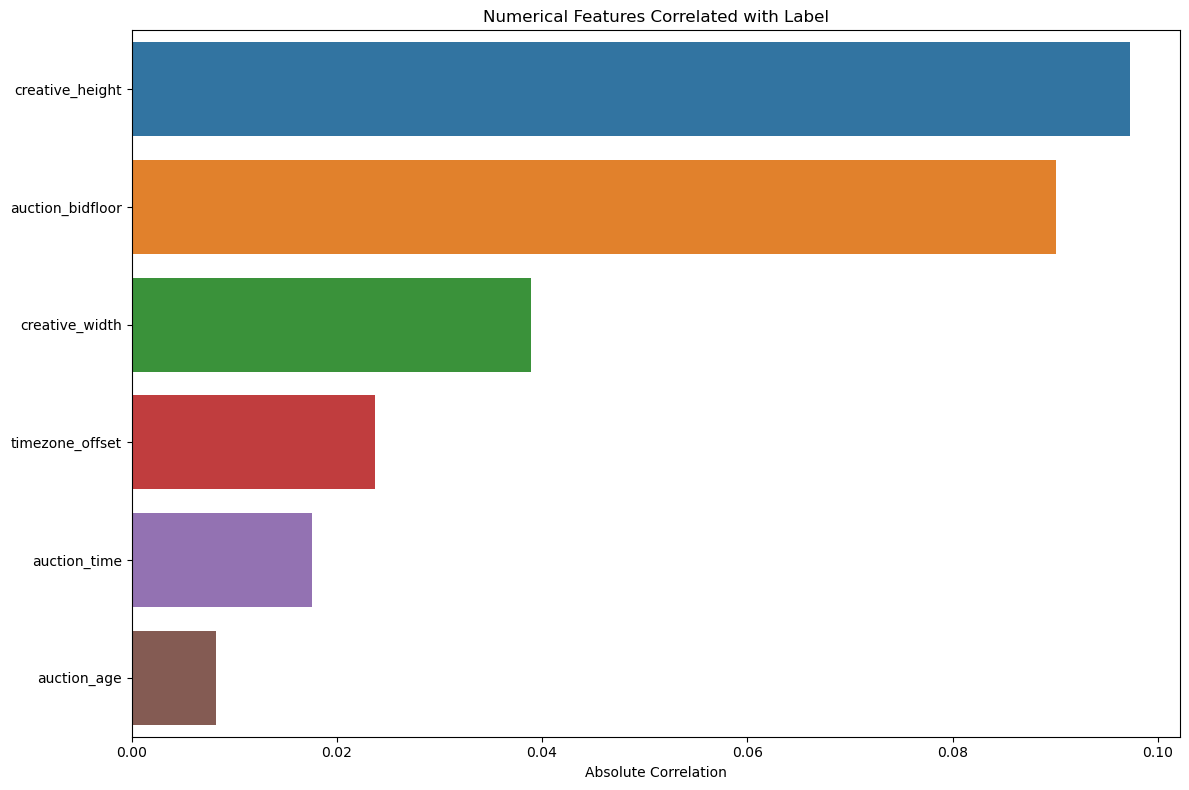

In [6]:
# Correlation analysis with 'Label'
numeric_data = train_data[numeric_columns]
correlation_with_label = numeric_data.corr()['Label'].sort_values(key=abs, ascending=False)

# Print correlations with 'Label'
print("Correlation of features with 'Label' (sorted by absolute value):")
for feature, corr in correlation_with_label.items():
    if feature != 'Label':
        print(f"{feature}: {corr:.4f}")

# Visualize top correlations with 'Label'
plt.figure(figsize=(12, 8))
top_correlations = correlation_with_label.drop('Label').abs()
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Numerical Features Correlated with Label')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

##### Categorical features

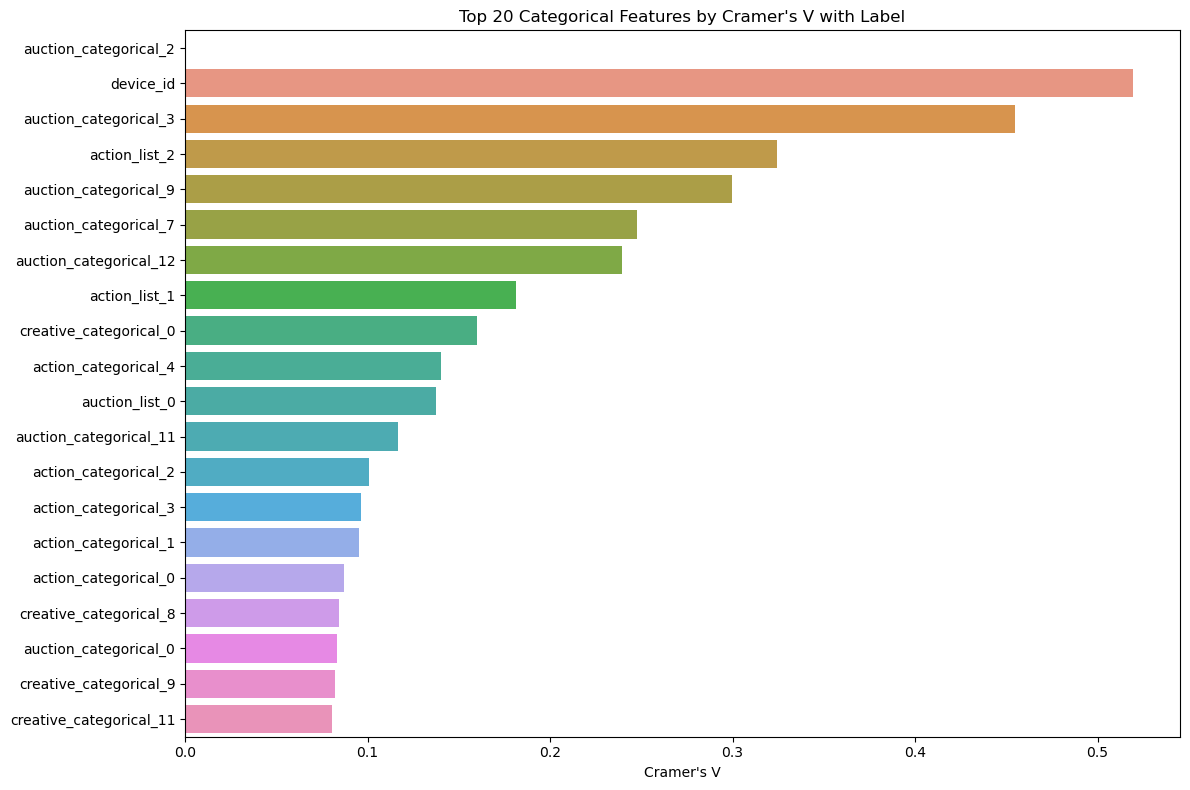

Cramer's V for categorical features with 'Label':
auction_categorical_2: nan
device_id: 0.5192
auction_categorical_3: 0.4548
action_list_2: 0.3244
auction_categorical_9: 0.2996
auction_categorical_7: 0.2474
auction_categorical_12: 0.2394
action_list_1: 0.1813
creative_categorical_0: 0.1602
action_categorical_4: 0.1401
auction_list_0: 0.1377
auction_categorical_11: 0.1169
action_categorical_2: 0.1010
action_categorical_3: 0.0964
action_categorical_1: 0.0953
action_categorical_0: 0.0873
creative_categorical_8: 0.0840
auction_categorical_0: 0.0831
creative_categorical_9: 0.0823
creative_categorical_11: 0.0803


In [7]:
# Calculate Cramer's V for each categorical feature with 'Label'
cramer_v_results = {}
for col in categorical_features:
    confusion_matrix = pd.crosstab(train_data[col], train_data['Label'])
    cramer_v_results[col] = cramers_v(confusion_matrix)

# Sort results
cramer_v_results = dict(sorted(cramer_v_results.items(), key=lambda item: item[1], reverse=True))

# Visualize top Cramer's V results
plt.figure(figsize=(12, 8))
top_features = dict(list(cramer_v_results.items())[:20])
sns.barplot(x=list(top_features.values()), y=list(top_features.keys()))
plt.title("Top 20 Categorical Features by Cramer's V with Label")
plt.xlabel("Cramer's V")
plt.tight_layout()
plt.show()

# Print results
print("Cramer's V for categorical features with 'Label':")
for feature, v in top_features.items():
    print(f"{feature}: {v:.4f}")

#### Missing values

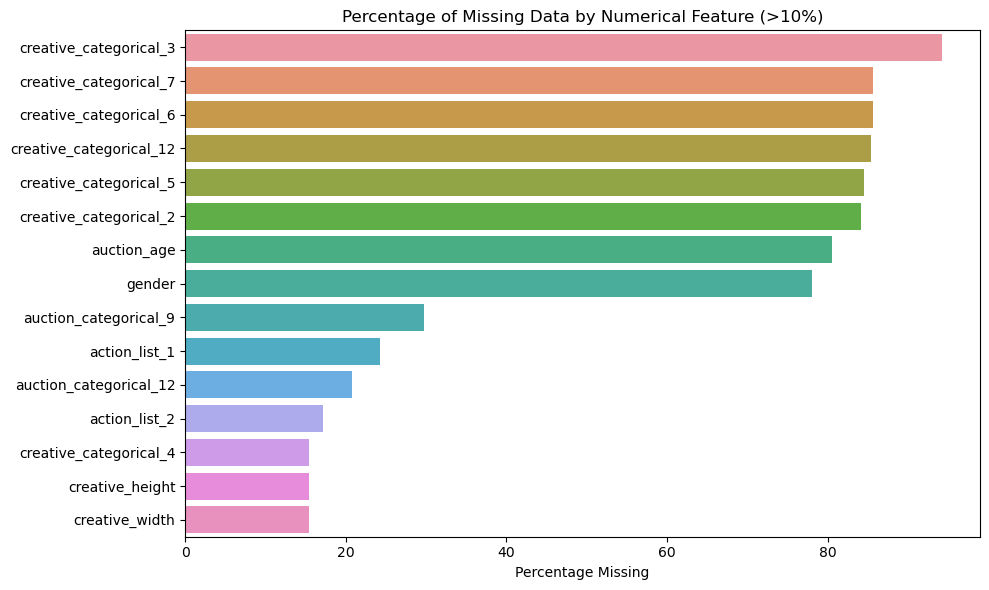


Percentage of Missing Data by Feature (>10% missing):
creative_categorical_3: 94.24%
creative_categorical_7: 85.66%
creative_categorical_6: 85.59%
creative_categorical_12: 85.38%
creative_categorical_5: 84.56%
creative_categorical_2: 84.12%
auction_age: 80.58%
gender: 77.98%
auction_categorical_9: 29.74%
action_list_1: 24.28%
auction_categorical_12: 20.70%
action_list_2: 17.13%
creative_categorical_4: 15.45%
creative_height: 15.42%
creative_width: 15.42%


In [8]:
# Análisis de datos faltantes (sin cambios)
missing_data = train_data.isnull().sum() / len(train_data) * 100
missing_data = missing_data[missing_data > 10].sort_values(ascending=False)  # Filtrar las columnas con más del 10% de datos faltantes

# Visualizar datos faltantes
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.values, y=missing_data.index)
plt.title('Percentage of Missing Data by Numerical Feature (>10%)')
plt.xlabel('Percentage Missing')
plt.tight_layout()
plt.show()

# Imprimir resultados
print("\nPercentage of Missing Data by Feature (>10% missing):")
for feature, percentage in missing_data.items():
    print(f"{feature}: {percentage:.2f}%")

#### Valores unicos y su frecuencia

In [9]:
# Iterar sobre cada columna y mostrar los valores únicos y la cantidad de veces que aparecen
for column in train_data.columns:
    if column not in ['auction_list_0', 'action_list_1', 'action_list_2', 'auction_time']:
        print(f"Columna: {column}")
        print(f"Valores únicos y su frecuencia:")
        print(train_data[column].value_counts())
        print("-" * 50)  # Separador entre columnas

Columna: Label
Valores únicos y su frecuencia:
Label
0    8351818
1     104210
Name: count, dtype: int64
--------------------------------------------------
Columna: action_categorical_0
Valores únicos y su frecuencia:
action_categorical_0
9915ffee    2205731
11b7af3d    1884078
604d011f    1419569
c2e4f717    1410061
e350c7c7     781816
c202ab08     512191
6b5513a4     145437
7f02cacc      68229
c186959e      28916
Name: count, dtype: int64
--------------------------------------------------
Columna: action_categorical_1
Valores únicos y su frecuencia:
action_categorical_1
f71d2f9b    1349435
ac0f362d    1176357
d9eb38d8    1109701
dc24b79b    1096030
3074db21    1023664
e220fce9     781816
0d132da2     707721
6d1ca31b     512191
e709bbc0     386397
62f19448     111606
49bef539      70134
f4cd321d      68229
df5eb4dc      33831
11fe6f26      28916
Name: count, dtype: int64
--------------------------------------------------
Columna: action_categorical_2
Valores únicos y su frecuencia:
ac

#### Levels features

In [14]:
level_features = ['action_categorical_0', 'action_categorical_1', 'action_categorical_2', 'action_categorical_3', 'action_categorical_4']

print(f"Valores únicos y su frecuencia:")
for column in train_data.columns:
    if column in level_features:
        print(f"Columna: {column}")
        print(train_data[column].value_counts())
        print("-" * 50)  # Separador entre columnas

Valores únicos y su frecuencia:
Columna: action_categorical_0
action_categorical_0
9915ffee    2205731
11b7af3d    1884078
604d011f    1419569
c2e4f717    1410061
e350c7c7     781816
c202ab08     512191
6b5513a4     145437
7f02cacc      68229
c186959e      28916
Name: count, dtype: int64
--------------------------------------------------
Columna: action_categorical_1
action_categorical_1
f71d2f9b    1349435
ac0f362d    1176357
d9eb38d8    1109701
dc24b79b    1096030
3074db21    1023664
e220fce9     781816
0d132da2     707721
6d1ca31b     512191
e709bbc0     386397
62f19448     111606
49bef539      70134
f4cd321d      68229
df5eb4dc      33831
11fe6f26      28916
Name: count, dtype: int64
--------------------------------------------------
Columna: action_categorical_2
action_categorical_2
2f2b9920    879759
1ae7a73f    594935
3786e6dc    578899
2e6c63bf    564614
c0f33c37    372597
             ...  
3fc21ae2       642
fbd3cd06       308
63b53000       156
633dc1e4        18
d6b97186   

In [15]:
# Bucle para contar los NaNs en cada columna
for column in level_features:
    num_nans = train_data[column].isna().sum()
    print(f"Columna {column} tiene {num_nans} valores NaN.")

Columna action_categorical_0 tiene 0 valores NaN.
Columna action_categorical_1 tiene 0 valores NaN.
Columna action_categorical_2 tiene 0 valores NaN.
Columna action_categorical_3 tiene 0 valores NaN.
Columna action_categorical_4 tiene 0 valores NaN.


                                     Combination  Frequency
0   11b7af3d_ac0f362d_2f2b9920_cb80abab_2c3ce269     460705
1   c2e4f717_3074db21_1ae7a73f_62c903fc_9715f8a7     321906
2   604d011f_f71d2f9b_3786e6dc_2427063c_d1cc9ed2     318875
3   604d011f_f71d2f9b_2e6c63bf_2427063c_50264f0a     288092
4   9915ffee_d9eb38d8_c0f33c37_9ebdf82c_6825a9aa     280124
5   9915ffee_d9eb38d8_20ae8708_9ebdf82c_e3d22e48     237879
6   9915ffee_dc24b79b_d2f34a41_7ce4e1a3_b55cb32e     232140
7   11b7af3d_0d132da2_8cc5b58e_f51428b0_74d281f4     204177
8   604d011f_f71d2f9b_3786e6dc_2427063c_de5febb8     171330
9   e350c7c7_e220fce9_8f1154ef_e9c266f7_cd404818     170391
10  9915ffee_dc24b79b_7c0ac8b2_7ce4e1a3_f7947e23     169571
11  604d011f_f71d2f9b_2e6c63bf_2427063c_11a8337e     157470
12  9915ffee_dc24b79b_090f19bf_7ce4e1a3_32443900     152294
13  11b7af3d_ac0f362d_2f2b9920_cb80abab_79ab88b6     152089
14  11b7af3d_ac0f362d_2f2b9920_cb80abab_89d11eb2     133082
15  604d011f_f71d2f9b_9e4f5826_2c66682b_

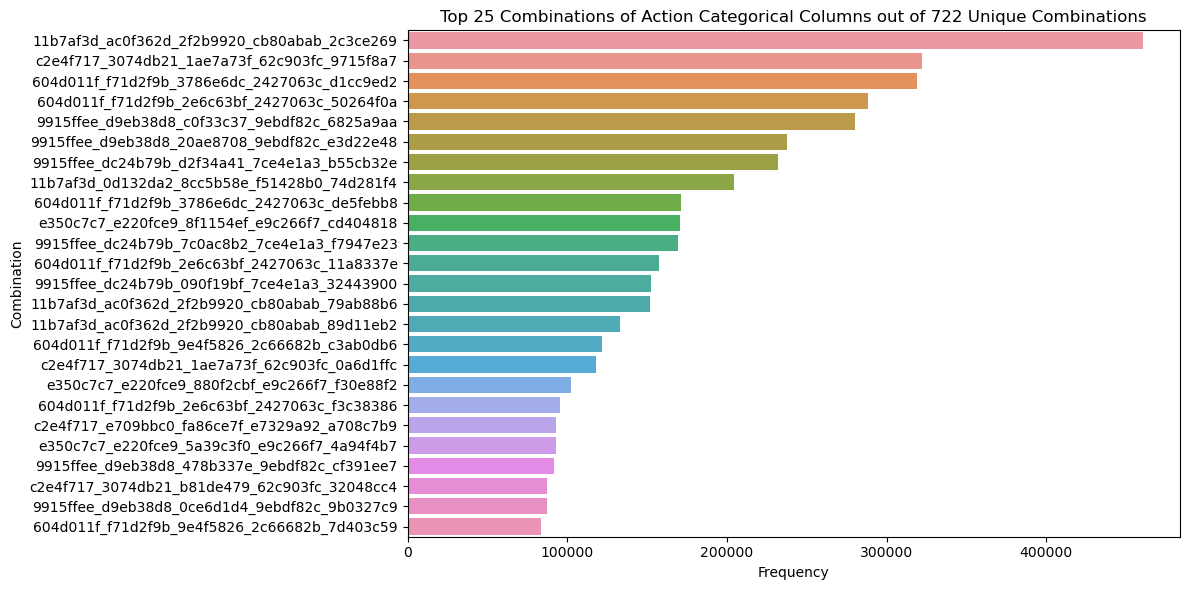

In [16]:
# Crear una columna con las combinaciones únicas de las 5 columnas
train_data['combination'] = (train_data['action_categorical_0'].astype(str) + '_' +
                             train_data['action_categorical_1'].astype(str) + '_' +
                             train_data['action_categorical_2'].astype(str) + '_' +
                             train_data['action_categorical_3'].astype(str) + '_' +
                             train_data['action_categorical_4'].astype(str))

# Obtener las combinaciones únicas y sus frecuencias
combination_counts = train_data['combination'].value_counts().reset_index()
combination_counts.columns = ['Combination', 'Frequency']

# Mostrar las primeras 10 combinaciones más comunes
print(combination_counts.head(25))
print(f"De: {len(combination_counts)} combinaciones únicas.")

# Graficar las combinaciones más frecuentes
plt.figure(figsize=(12, 6))
top_combinations = combination_counts.head(25)  # Mostrar las 25 combinaciones más comunes
sns.barplot(x='Frequency', y='Combination', data=top_combinations)
plt.title("Top 25 Combinations of Action Categorical Columns out of {} Unique Combinations".format(len(combination_counts)))
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [34]:
# Combinaciones menos comunes (< 10000 veces)
print(combination_counts[combination_counts['Frequency'] <= 10000])

# Suma de todas las frecuencias de las combinaciones menos comunes
print(f"Suma de las frecuencias de las combinaciones menos comunes: {combination_counts[combination_counts['Frequency'] <= 10000]['Frequency'].sum()}")


                                      Combination  Frequency
137  11b7af3d_ac0f362d_8ec192a6_cb80abab_d8ad09ac       9935
138  11b7af3d_0d132da2_c2e18ba5_f51428b0_f49ac1a3       9709
139  9915ffee_dc24b79b_35fedca8_7ce4e1a3_071129d3       9562
140  e350c7c7_e220fce9_dac70ca7_e9c266f7_19b3ece6       9405
141  11b7af3d_0d132da2_8cc5b58e_f51428b0_ec52eb79       9340
..                                            ...        ...
717  9915ffee_d9eb38d8_4ff3d978_9ebdf82c_1355ebbf          1
718  6b5513a4_df5eb4dc_3fc21ae2_8c258838_00cd999a          1
719  c202ab08_6d1ca31b_75f68f1d_93071c6b_53920029          1
720  c202ab08_6d1ca31b_6991750b_a5ce0e31_e43913cc          1
721  11b7af3d_ac0f362d_731c5b17_cb80abab_f666a8ba          1

[585 rows x 2 columns]
Suma de las frecuencias de las combinaciones menos comunes: 973926


#### Boolean Features

In [44]:
boolean_features = ['auction_boolean_0', 'auction_boolean_1', 'auction_boolean_2']

for column in train_data.columns:
    if column in boolean_features:
        print(f"Columna: {column}")
        print(f"Valores únicos y su frecuencia:")
        print(train_data[column].value_counts())
        print("-" * 50)

Columna: auction_boolean_0
Valores únicos y su frecuencia:
auction_boolean_0
47980dda    5880872
79ceee49    2318508
43c867fd     101631
Name: count, dtype: int64
--------------------------------------------------
Columna: auction_boolean_1
Valores únicos y su frecuencia:
auction_boolean_1
79ceee49    8181934
47980dda       3085
Name: count, dtype: int64
--------------------------------------------------
Columna: auction_boolean_2
Valores únicos y su frecuencia:
auction_boolean_2
65dcab89    8170420
43c867fd      33363
Name: count, dtype: int64
--------------------------------------------------


In [45]:
# Bucle para contar los NaNs en cada columna
for column in boolean_features:
    num_nans = train_data[column].isna().sum()
    print(f"Columna {column} tiene {num_nans} valores NaN.")

Columna auction_boolean_0 tiene 155017 valores NaN.
Columna auction_boolean_1 tiene 271009 valores NaN.
Columna auction_boolean_2 tiene 252245 valores NaN.


Creamos una funcion para resolverl el problema de los valores booleanos

In [7]:
# Crear un DataFrame de ejemplo
data = {
    'auction_boolean_0': ['47980dda', '43c867fd', None, '79ceee49'],
    'auction_boolean_1': ['79ceee49', None, '79ceee49', None],
    'auction_boolean_2': ['65dcab89', None, '43c867fd', '65dcab89']
}

# Crear el DataFrame
train_data = pd.DataFrame(data)

# Imprimir el DataFrame original
print("DataFrame Original:")
print(train_data)

# Aplicar la función personalizada de one-hot encoding
train_data_encoded = boolean_features_ohe(train_data)

# Imprimir el DataFrame resultante
print("\nDataFrame después del One-Hot Encoding personalizado:")
print(train_data_encoded)

DataFrame Original:
  auction_boolean_0 auction_boolean_1 auction_boolean_2
0          47980dda          79ceee49          65dcab89
1          43c867fd              None              None
2              None          79ceee49          43c867fd
3          79ceee49              None          65dcab89

DataFrame después del One-Hot Encoding personalizado:
   47980dda  43c867fd  79ceee49  65dcab89
0         1         0         1         1
1         0         1         0         0
2         0         1         1         0
3         0         0         1         1


#### Time features

In [25]:
time_features = ['auction_time', 'auction_age', 'timezone_offset']

for column in train_data.columns:
    if column in time_features:
        print(f"Columna: {column}")
        print(f"Valores únicos y su frecuencia:")
        print(train_data[column].value_counts())
        print("-" * 50)

Columna: auction_age
Valores únicos y su frecuencia:
auction_age
25.0     111861
27.0      92915
29.0      89353
28.0      86159
30.0      80419
          ...  
124.0         5
121.0         5
119.0         4
84.0          1
123.0         1
Name: count, Length: 113, dtype: int64
--------------------------------------------------
Columna: auction_time
Valores únicos y su frecuencia:
auction_time
1.516551e+09    4
1.516530e+09    4
1.516528e+09    4
1.516528e+09    4
1.516567e+09    4
               ..
1.516432e+09    1
1.516417e+09    1
1.516417e+09    1
1.516417e+09    1
1.516042e+09    1
Name: count, Length: 8378856, dtype: int64
--------------------------------------------------
Columna: timezone_offset
Valores únicos y su frecuencia:
timezone_offset
1.0     6704369
4.0     1448485
10.0     270135
8.0       16314
9.5        8451
Name: count, dtype: int64
--------------------------------------------------


In [27]:
# Bucle para contar los NaNs en cada columna
for column in time_features:
    num_nans = train_data[column].isna().sum()
    print(f"Columna {column} tiene {num_nans} valores NaN.")

Columna auction_time tiene 0 valores NaN.
Columna auction_age tiene 6813904 valores NaN.
Columna timezone_offset tiene 8274 valores NaN.


In [ ]:
# Asegúrate de tener la columna 'auction_age' en tu train
if 'auction_age' in train_data.columns:
    # Obtener los valores únicos y su frecuencia
    unique_ages = train_data['auction_age'].value_counts().sort_index()

    # Imprimir cada edad y su frecuencia
    for age, frequency in unique_ages.items():
        print(f"Edad: {age}, Frecuencia: {frequency}")


##### Funcion para crear atributos temporales

In [11]:
# time_features_extension

data = {
    'auction_time': [
        1545676800,  # 24 de Diciembre de 2018, 22:00:00
        1483228800,  # 31 de Diciembre de 2016, 23:00:00
        1288396800,  # 30 de Octubre de 2010, 10:00:00
        1412899200,  # 10 de Octubre de 2014, 15:00:00
        1483574400   # 5 de Enero de 2017, 09:00:00
    ],
    'timezone_offset': [1, -2, 3, 0, 5]  # Diferentes zonas horarias
}

df = pd.DataFrame(data)

df = time_features_extension(df)

# Imprimir el DataFrame resultante
print("\nDataFrame después de procesar el tiempo de subasta:")
print(df)


DataFrame después de procesar el tiempo de subasta:
   week_day time_of_month moment_of_the_day  close_to_festivity
0         1             3                 3                   1
1         6             3                 3                   1
2         6             3                 1                   1
3         5             1                 1                   0
4         4             1                 1                   1


In [7]:
# age_group

data = {
    'auction_age': [
        -1, 15, 25, 35, 50, 65, 105, 80, 18, 99, 0, 579
    ]
}

# Crear el DataFrame
df = pd.DataFrame(data)

df = age_group(df, 'auction_age')
print(df)

    age_group
0           0
1           1
2           2
3           3
4           4
5           5
6           0
7           5
8           1
9           5
10          1
11          0


### Análisis: Test vs Train

#### En test pero no en train

In [ ]:
columns_to_exclude = ['auction_list_0', 'action_list_1', 'action_list_2', 'auction_time', 'auction_boolean_0', 'auction_boolean_1', 'auction_boolean_2']
categorical_features_ = [col for col in categorical_features if col not in columns_to_exclude]

In [24]:
# Crear un diccionario para almacenar las categorías desconocidas por columna
categorias_desconocidas = {}

# Iterar a través de cada columna categórica
for columna in categorical_features_:
    # Obtener las categorías únicas en el conjunto de entrenamiento
    categorias_train = set(train_data[columna].dropna().unique())
    
    # Obtener las categorías únicas en el conjunto de prueba
    categorias_test = set(test[columna].dropna().unique())
    
    # Identificar las categorías en test que no están en train
    desconocidas = categorias_test - categorias_train
    
    # Almacenar las categorías desconocidas en el diccionario como una lista
    categorias_desconocidas[columna] = list(desconocidas)

    # Inicializamos una máscara booleana que será True si la fila tiene una categoría desconocida en cualquier columna
mask = pd.Series([False] * len(test))

# Iteramos a través de cada columna categórica
for columna in categorias_desconocidas:
    # Verificamos si el valor en la columna está dentro de las categorías desconocidas
    mask = mask | test[columna].isin(categorias_desconocidas[columna])

# Contamos el número de filas donde al menos una categoría es desconocida
num_filas_desconocidas = mask.sum()

print(f"Cantidad de filas con al menos una categoría desconocida (existe en test y no en train): {num_filas_desconocidas} ({num_filas_desconocidas / len(test) * 100:.2f}%)")

Cantidad de filas con al menos una categoría desconocida (existe en test y no en train): 712137 (62.49%)


#### En train pero no en test

In [23]:
# Crear un diccionario para almacenar las categorías desconocidas por columna
categorias_conocidas = {}

# Iterar a través de cada columna categórica
for columna in categorical_features_:
    # Obtener las categorías únicas en el conjunto de entrenamiento
    categorias_test = set(test[columna].dropna().unique())
    
    # Obtener las categorías únicas en el conjunto de prueba
    categorias_train = set(train_data[columna].dropna().unique())
    
    # Identificar las categorías en test que no están en train
    conocidas = categorias_train - categorias_test
    
    # Almacenar las categorías desconocidas en el diccionario como una lista
    categorias_conocidas[columna] = list(conocidas)

# Inicializamos una máscara booleana que será True si la fila tiene una categoría desconocida en cualquier columna
mask = pd.Series([False] * len(test))

# Iteramos a través de cada columna categórica
for columna in categorias_conocidas:
    # Verificamos si el valor en la columna está dentro de las categorías desconocidas
    mask = mask | train_data[columna].isin(categorias_conocidas[columna])

# Contamos el número de filas donde al menos una categoría es desconocida
num_filas_conocidas = mask.sum()

print(f"Cantidad de filas con al menos una categoría que no existe en test: {num_filas_conocidas} ({num_filas_conocidas / len(train_data) * 100:.2f}%)")

Cantidad de filas con al menos una categoría que no existe en test: 5513451 (65.20%)


## Procesamiento de datos

In [ ]:
train_data_cleaned = process_data_with_dask(train_data, npartitions=20)

In [ ]:
train_data_cleaned.to_csv('train_data_cleaned.csv', index=False)

In [ ]:
train_data_cleaned = pd.read_csv('train_data_cleaned.csv')

# Entrenamiento de modelos

In [ ]:
test_data = pd.read_csv('data/ctr_test.csv')

# test_data_cleaned = process_data_with_dask(test_data, npartitions=2)

test_data_cleaned = pd.read_csv('test_data_cleaned.csv')

### Target Encoding

In [ ]:
# Dividir los datos en entrenamiento y validación con estratificación
X_train, X_val, y_train, y_val = train_test_split(
    train_data_cleaned.drop(columns='Label'),  # Características
    train_data_cleaned['Label'],               # Variable objetivo
    test_size=0.2,                              # 20% para validación
    stratify=train_data_cleaned['Label'],      # Estratificación basada en la variable objetivo
    random_state=random_state                   # Semilla para reproducibilidad
)

# Verificar la proporción de clases en el conjunto de entrenamiento y validación
print("Proporción en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("Proporción en el conjunto de validación:")
print(y_val.value_counts(normalize=True))

In [ ]:
# Definir las columnas categóricas a codificar
categorical_features_to_encode = col in X_train.select_dtypes(include=['object']).columns

# Crear el Target Encoder para las columnas categóricas
target_encoder = ce.TargetEncoder(cols=categorical_features_to_encode)

# Crear el imputador
imputer = SimpleImputer(strategy='mean')

model_xgb_te = XGBClassifier(random_state=random_state)

pipeline_xgb_te = Pipeline(steps=[
    ('target_encoder', target_encoder),  # Paso de Target Encoding
    ('imputer', imputer),                # Paso de imputación
    ('classifier', model_xgb_te)         # Paso de Xgboost
])